In [ ]:
#Claudia Patricia Oviedo Santacruz
#Modelos de Aprendizaje Profundo para la Detección Automática de Noticias Falsas


##Proyecto: Detección de noticias falsas: comparación entre modelos de aprendizaje profundo basado en redes neuronales y modelos de lenguaje de gran escala.

### Descripción del problema

### Conociendo los datos
el dataset contiene información de noticias clasificadas como confiables o poco confiables, tiene los siguientes atributos: \\

**id**: un id unico para cada articulo de noticia\
**title**: título del articulo de noticia\
**author**: autor del arculo de noticia\
**text**; el texto del artículo\
**label**: una etiqueta que marca un articulo como potencialmente poco confiable\\

1: poco confiable\

0: confiable

In [ ]:
 #importamos las librerias necesarias para el procesamiento de los datos
!pip install keras-tuner --upgrade -q

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay , classification_report , roc_curve


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras_tuner import RandomSearch

#from tensorflow.keras.layers import LSTM, Dense
#from tensorflow.keras.layers import Embedding

#from tensorflow.python.keras.preppreprocessing.text import one_hot

#from tensorflow.python.keras.preprocessing.text import one_hot
#from tensorflow.keras.preprocessing.text import one_hot
#

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    phrase = re.sub(r"u.s.", " us", phrase)
    return phrase



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

#Leemos los datos de entrenamiento
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df.head(7)



,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1


In [ ]:
df.dtypes

#Se evidencia que los datos tienen diferentes tipos de datos


,0
id,int64
title,object
author,object
text,object
label,int64


In [ ]:
#Leemos los datos de prueba
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
#Tamaño del dataframe
df.shape

(20800, 5)

In [ ]:
df.groupby('label').size()

,0
label,
0,10387
1,10413


In [ ]:
##Leemos los datos de las etiquetas de los datos de prueba
df_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/submit.csv')
df_submit.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [ ]:
df_submit.shape
df_submit.groupby('label').size()

,0
label,
0,2339
1,2861


In [ ]:
#El dataframe de entrenamiento tiene un tamaño de 5 columnas (atributos) por 20800 filas de registros
#El dataframe de prueba tiene un tamaño de 4 columnas por 5.200 filas de registros
#revisamos si el dataframe de entrenamiento tienen registros vacios (null)
df.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [ ]:
#contiene un total de 2554 registros nulos del total de 20.800, por lo que se eliminan estos datos
df=df.dropna()
#Verificando el resultado:
df.isnull().sum()
df.shape

(18285, 5)

In [ ]:
#el dataframe contiene entonces una matriz de 5 atributos por 18.285 registros de noticias
#Distribución de Clases (0 confiable, 1 poco confiable):

df.groupby('label').size()


,0
label,
0,10361
1,7924


Revisión de autores:

In [ ]:
# Revisamos la distribución de los autores para cada tipo de noticias:
#autores que contribuyeron a noticias falsas:
autores_falsos= set(df[df['label']==1]['author'].dropna())
#autores que contribuyeron a noticias verdaderas:
autores_verdaderos= set(df[df['label']==0]['author'].dropna())
#describimos los autores unicos que contribuyeron a cada tipo:
autores_verdaderos_unicos= autores_verdaderos - autores_falsos
autores_falsos_unicos= autores_falsos - autores_verdaderos

print("Numero de autores que solamente escriben noticias falsas:", len(autores_falsos_unicos))
print("Numero de autores que solamente escriben noticias verdaderas:", len(autores_verdaderos_unicos))
print("Numero de autores que escriben ambas noticias falsas o verdaderas :", len(autores_falsos & autores_verdaderos))
print("Numero total de autores :", len(autores_falsos | autores_verdaderos))

#solo una parte pequeña de autores contribuyen a ambos tipos de noticias

Numero de autores que solamente escriben noticias falsas: 1613
Numero de autores que solamente escriben noticias verdaderas: 2220
Numero de autores que escriben ambas noticias falsas o verdaderas : 5
Numero total de autores : 3838



Distribución del conteo de palabras para el atributo título

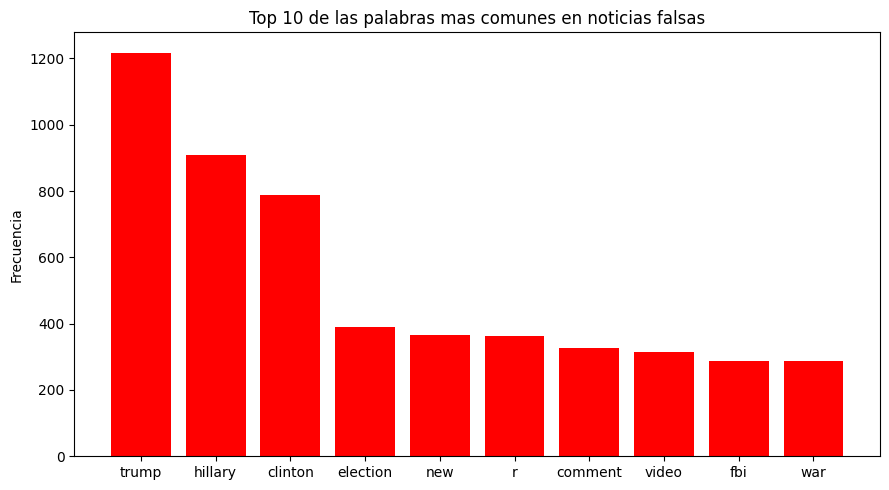

palabras de noticias falsas mas comunes:
('trump', 'hillary', 'clinton', 'election', 'new', 'r', 'comment', 'video', 'fbi', 'war')


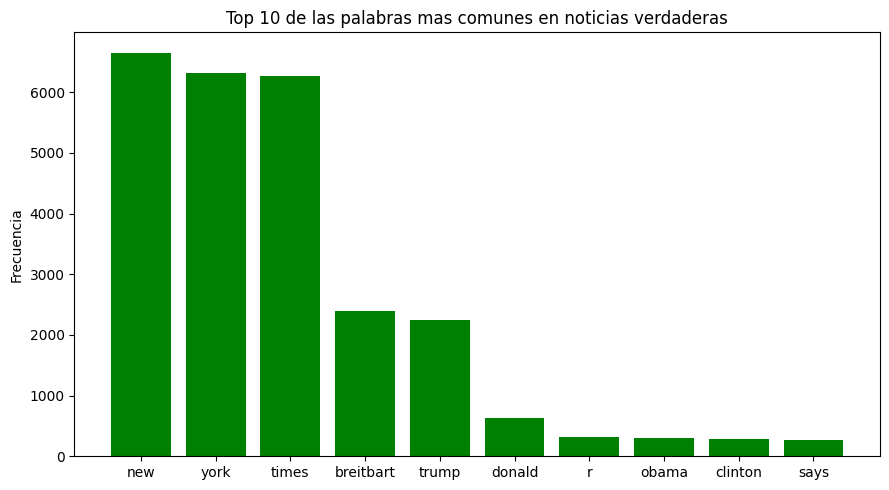

palabras de noticias verdaderas mas comunes:
('new', 'york', 'times', 'breitbart', 'trump', 'donald', 'r', 'obama', 'clinton', 'says')


In [ ]:
#limpiamos el texto de los títulos y los clasificamos por label
titulos_falsos= " ".join(df[df['label'] == 1]['title'].dropna()).lower()
titulos_falsos=decontracted(titulos_falsos)
titulos_falsos= re.sub(r'[^a-zA-Z]',' ', titulos_falsos).split()

titulos_verdaderos= " ".join(df[df['label'] == 0]['title'].dropna()).lower()
titulos_verdaderos=decontracted(titulos_verdaderos)
titulos_verdaderos= re.sub(r'[^a-zA-Z]',' ', titulos_verdaderos).split()
#removemos los stopwords
conteo_palabras_falsas = Counter ([palabra for palabra in titulos_falsos if palabra not in ENGLISH_STOP_WORDS])
conteo_palabras_verdaderas= Counter ([palabra for palabra in titulos_verdaderos if palabra not in ENGLISH_STOP_WORDS])


#tomamos las 10 palabras mas comunes
palabras_falsas_comunes= dict(conteo_palabras_falsas.most_common(10))
palabras_verdaderas_comunes=dict(conteo_palabras_verdaderas.most_common(10))

#separamos conteo y palabras para el grafico
palabras_falsas, conteo_falsas= zip(*palabras_falsas_comunes.items())
palabras_verdaderas, conteo_verdaderas= zip(*palabras_verdaderas_comunes.items())

plt.figure(figsize=(9,5))
plt.bar ( palabras_falsas, conteo_falsas, color='red')
plt.title("Top 10 de las palabras mas comunes en noticias falsas")
plt.ylabel("Frecuencia")
plt.gca()#.invert_yaxis()
plt.tight_layout()
plt.show()
print(f'palabras de noticias falsas mas comunes:\n{palabras_falsas}')

plt.figure(figsize=(9,5))
plt.bar(palabras_verdaderas, conteo_verdaderas, color='green')
plt.title("Top 10 de las palabras mas comunes en noticias verdaderas")
plt.ylabel("Frecuencia")
plt.gca()
plt.tight_layout()
plt.show()
print(f'palabras de noticias verdaderas mas comunes:\n{palabras_verdaderas}')

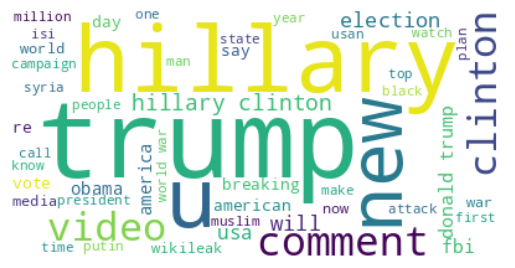

In [ ]:
#Creamos la nube de palabras para los títulos de las noticias falsas
texto_falso=" ".join(titulos_falsos)
wordcloud = WordCloud(max_words=50,background_color="white").generate(texto_falso)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

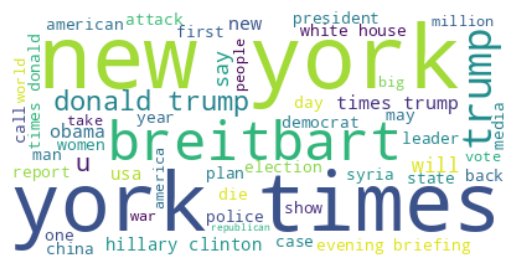

In [ ]:
#Creamos la nube de palabras para los títulos de las noticias Verdaderas

texto_verdadero=" ".join(titulos_verdaderos)
wordcloud = WordCloud(max_words=50,background_color="white").generate(texto_verdadero)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Pasos para el procesamiento de datos texto:
#tokenización, convertir a minúsculas, la eliminación de stopwords, signos de puntuación, stemming.

#stemming deja la raiz de la palabra


stemmer = PorterStemmer()
corpus= []
corpus_test=[]
iterador_titulo= iter(df['title'])

for titulo in iterador_titulo:
  datos= re.sub(r'[^a-zA-Z]',' ', titulo)
  datos = datos.lower().split()
  datos = [stemmer.stem(palabra) for palabra in datos if not palabra in stopwords.words('english')]
  datos = ' '.join(datos)
  corpus.append(datos)


print("Títulos sin preprocesar")
print(df['title'][0])
print("Títulos preprocesados")
print(corpus[0])

df['cleantitle']= corpus
df.head(7)


Títulos sin preprocesar
House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
Títulos preprocesados
hous dem aid even see comey letter jason chaffetz tweet


,id,title,author,text,label,cleantitle
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,hous dem aid even see comey letter jason chaff...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillari clinton big woman campu breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,civilian kill singl us airstrik identifi
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jail fiction unpublish stori wom...
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,jacki mason hollywood would love trump bomb no...
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,beno hamon win french socialist parti presiden...


In [ ]:
corpus_test=[]
iterador_titulo_test=iter(df_test['title'])

for titulo in iterador_titulo_test:
  datos= re.sub(r'[^a-zA-Z]',' ', str(titulo))
  datos = datos.lower().split()
  datos = [stemmer.stem(palabra) for palabra in datos if not palabra in stopwords.words('english')]
  datos = ' '.join(datos)
  corpus_test.append(datos)

print("Títulos test sin preprocesar")
print(df_test['title'][0])
print("Títulos test preprocesados")
print(corpus_test[0])

df_test['cleantitle']= corpus_test
df_test.head(7)

Títulos test sin preprocesar
Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley - The New York Times
Títulos test preprocesados
specter trump loosen tongu purs string silicon valley new york time


,id,title,author,text,cleantitle
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",specter trump loosen tongu purs string silicon...
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warship readi strike terrorist near al...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,nodapl nativ american leader vow stay winter f...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",tim tebow attempt anoth comeback time basebal ...
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report meme war e
5,20805,Trump is USA's antique hero. Clinton will be n...,NaN,Trump is USA's antique hero. Clinton will be n...,trump usa antiqu hero clinton next presid
6,20806,Pelosi Calls for FBI Investigation to Find Out...,Pam Key,"Sunday on NBC’s “Meet the Press,” House Minori...",pelosi call fbi investig find russian donald t...


In [ ]:
#Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleantitle'])
sequences = tokenizer.texts_to_sequences(df['cleantitle'])
print(sequences)
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
print(padded_sequences)
print(padded_sequences.shape)

[[31, 221, 243, 50, 142, 102, 509, 1775, 3009, 420], [829, 6, 7, 110, 150, 1090, 5], [335, 856, 33, 83], [567, 34, 1157, 20, 887, 1682], [1187, 150, 597, 3305, 7835, 253, 150, 1459, 135, 7836], [3306, 3010, 339, 162, 278, 4, 195, 132, 323, 1242, 2109, 1298, 244, 15, 5], [5913, 5914, 49, 379, 2387, 128, 167, 857, 1, 3, 2], [54, 1393, 39, 1091, 18, 5915, 4, 1158, 1, 3, 2], [12, 911, 586, 2110, 271, 336, 7837, 1299, 4, 858], [1188, 1872, 4838, 178, 5916, 96, 432, 1159], [58, 1125, 802, 209, 1047, 248, 706, 4178, 3011, 3012, 298], [20, 103, 142, 336, 4, 18], [1997, 803, 97, 1300, 425, 37, 1539, 4179, 1048], [373, 1394, 1395, 4839, 86, 134, 1009, 1, 3, 2], [778, 1460, 190, 4840, 337, 1, 3, 2], [976, 735, 233, 70, 180, 1010, 109, 395, 460, 317], [30, 258, 6], [1776, 1873, 2111, 8, 4, 71, 804, 5], [4180, 7838, 7, 206, 249, 217, 25, 229, 253], [2225, 7839, 4, 805, 7840, 5], [568, 1874, 107, 259, 2568, 25, 59, 469, 859, 1, 3, 2], [2112, 176, 1189, 1777, 75, 212, 450], [244, 122, 14, 42, 598, 16

In [ ]:
tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(df_test['cleantitle'])
sequences_test = tokenizer.texts_to_sequences(df_test['cleantitle'])
print(sequences_test)
max_len = max(len(seq) for seq in sequences_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')
print(padded_sequences_test)
print(padded_sequences_test.shape)

[[4, 3958, 6659, 7477, 7582, 1823, 1584, 1, 3, 2], [58, 4126, 465, 213, 222, 424, 189], [3677, 1738, 25, 108, 598, 1017, 1444, 775, 853, 36], [1002, 2683, 659, 240, 4013, 2, 2028, 1, 3, 2], [6128, 19, 1806, 16, 290], [4, 708, 13419, 1191, 7, 289, 13], [1469, 28, 30, 64, 86, 58, 8, 4, 5], [4439, 1893, 2385, 12045, 7085], [2762, 1021, 1163, 47, 307, 101, 753], [], [10, 230, 2078, 594, 4, 1807, 190], [114, 621, 1191, 159], [259, 4337, 1035, 478, 78, 936, 505], [1679, 117, 1127, 585], [1155, 5083, 93, 2517, 410, 803, 264, 17, 5233, 4, 56, 708, 3769], [4745, 55, 101, 2329, 1602, 1632, 1, 3, 2], [1, 2128, 671, 996, 196, 5634, 81, 137, 343, 5484, 2258, 1, 3, 2], [358, 88, 6923, 696, 576, 759, 694, 500, 5], [4, 2704, 211, 20, 8110, 869, 551, 9, 7], [473, 156, 534, 1477, 134, 1, 3, 2], [3014, 3550, 2556, 3034, 360, 1699, 737], [13, 12, 13, 9, 8, 4, 164, 35, 31], [], [178, 847, 583, 4, 49, 405], [759, 694, 204, 4825, 3094, 1076, 7599, 773, 1435, 49, 1665, 277], [662, 1214, 13803, 593, 4321, 77, 

In [ ]:

x_train=padded_sequences
y_train=df['label']
#print(len(y_train))
#print(len(x_train))
#x_test=padded_sequences_test
#y_test=df_test_labels['label']
#print(y_test.unique())

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

14628
3657
14628
3657


In [ ]:
print(tokenizer.word_index.popitem())
len(tokenizer.word_index)

('kratom', 13931)


13930

In [ ]:
#Creamos el primer modelo
# Long Short-Term Memory (LSTM)
voc_size=20000
embedding_vector_features = 40 #Feature Representation


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, output_dim= embedding_vector_features),
    tf.keras.layers.LSTM(10), # LSTM con 10 neuronas
    tf.keras.layers.Dense(1, activation='sigmoid')  # clasificación binaria 0 o 1
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#model.fit(x_train, y_train, epochs=10, verbose=1, validation_split=0.2)
history=model.fit(X_train,Y_train,validation_data=( X_test,Y_test),epochs=10)


Epoch 1/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6576 - loss: 0.5865 - val_accuracy: 0.6371 - val_loss: 0.6349
Epoch 2/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8511 - loss: 0.4038 - val_accuracy: 0.8819 - val_loss: 0.3628
Epoch 3/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.8968 - loss: 0.3284 - val_accuracy: 0.8720 - val_loss: 0.3797
Epoch 4/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.8917 - loss: 0.3313 - val_accuracy: 0.8685 - val_loss: 0.3864
Epoch 5/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.8895 - loss: 0.3330 - val_accuracy: 0.8663 - val_loss: 0.3931
Epoch 6/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8929 - loss: 0.3224 - val_accuracy: 0.8663 - val_loss: 0.3934
Epoch 7/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8989 - loss: 0.3070 - val_accuracy: 0.8663 - val_loss: 0.4000
Epoch 8/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9037 - loss: 0.2938 - 

In [ ]:
loss, accuracy = model.evaluate (X_test,Y_test)
print(f" Accuracy en el conjunto de test : { accuracy*100:.2f}%")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8661 - loss: 0.3934
 Accuracy en el conjunto de test : 87.23%


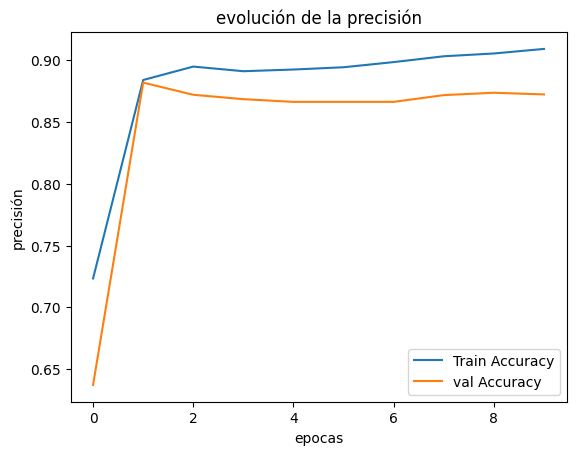

In [ ]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label= "val Accuracy")
plt.title("evolución de la precisión")
plt.xlabel("epocas")
plt.ylabel("precisión")
plt.legend()
plt.show()

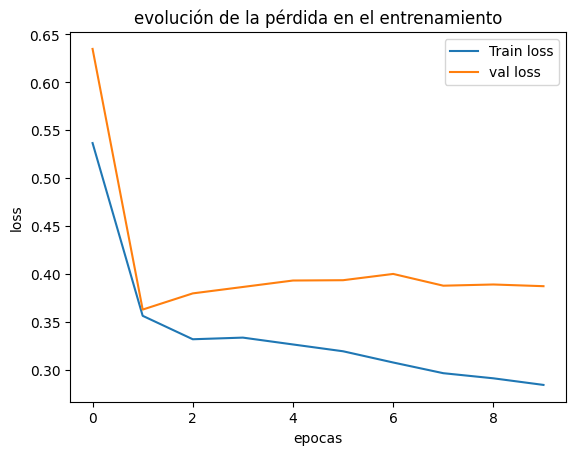

In [ ]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label= "val loss")
plt.title("evolución de la pérdida en el entrenamiento")
plt.xlabel("epocas")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
#print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 47, 40)              │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10)                  │           2,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,406,155 (9.18 MB)

 Trainable params: 802,051 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,604,104 (6.12 MB)

None
